# Google News Recommendations

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
import random
from scipy.stats import norm
from sklearn.preprocessing import LabelBinarizer

In [0]:
def random_argmax(rng, list_):
    """ similar to np.argmax but return a random element among max
        when multiple max exists."""
    return rng.choice(np.argwhere(list_ == list_.max()).flatten())

In [0]:
np.set_printoptions(precision=2)

## Environment



In [0]:
class Users:
    """
        Google News Users Class. 
        Init input :
            n_sources : int, Number of different sources (news website)
            n_themes : int, Number of different themes (7 at the moment on Google News)
            n_users : int, Number of Users
        Attributes :
            all of the above
            self.users_data : list, [preferences_sources, preferences_themes, next_log]
    """
    def __init__(self, n_themes, n_sources, n_users):
        self.n_users = n_users
        self.n_themes = n_themes
        self.n_sources = n_sources

        self.users_data = None

        #Call Maker function
        self.make_users_data()

    def make_users_data(self):
        """
            Makes up Data on every users.
            Each users_data is made of :
                preferences_sources : np.array(self.n_users, self.n_sources), stochastic vector 
                                     embedding user's preferences in regard to an article's theme
                preferences_themes : np.array(self.n_users, self.n_sources), stochastic vector 
                                     embedding user's preferences in regard to an article's source 
                next_log : int, in how many days will it be before the user next log

            Returns Nothing.
            Updates self.users_data.
        """
        ##Sources (Uniform for maximum entropy, continuous)
        preferences_sources = np.random.rand(self.n_users, self.n_sources)
        preferences_sources = preferences_sources / preferences_sources.sum(axis=1)[:,None]

        ##Themes (Uniform for maximum entropy, discrete (0-1))
        preferences_themes = np.random.randint(0, 2, size=(self.n_users, self.n_themes))
        #Stochastic Vector (normalizing)
        preferences_themes = preferences_themes / preferences_themes.sum(axis=1)[:,None]

        ##Next Log
        #On the first iteration, every user will log in the next day
        next_log = np.ones((self.n_users, 1))

        ##Save up everything
        self.users_data = [preferences_themes, preferences_sources, next_log]

    def set_next_log(self, index_user, next_log_i):
        self.users_data[2][index_user] = next_log_i

In [0]:
class Items:
    """
        Google News Items (articles) Class.
        Init Input :
            n_exp : int, Experience Span (in days)
            n_articles : int, Number of articles per day
            n_sources : int, Number of different sources (news website)
            n_themes : int, Number of different themes (7 at the moment on Google news)
        Attributes :
            all of the above 
            self.articles : np.array(size=(3, n_exp, n_articles)), [source, theme, hours]
    """
    def __init__(self, n_exp, n_articles, n_themes, n_sources):
        self.n_exp = n_exp
        self.n_articles = n_articles
        self.n_themes = n_themes
        self.n_sources = n_sources
        self.articles = None
        
        #Call maker function
        self.make_articles()

    def make_articles(self):
        """
            Makes up every articles on the whole experience span.
            Within a single day, there are n_articles articles. Each article is made of :
                hour : int 0-23, Hour at which the article is published
                theme : int 0-(n_themes-1), Index of the theme the article belongs to
                source : int 0-(n_sources-1), Index of the source the article comes from
            Returns Nothing.
            Updates self.articles. Expected dimension : (3, n_exp, n_articles)
        """
        ##Themes
        #To each day its headline; each day a theme is prevailing over the others
        headlines = np.asarray([np.random.randint(0, self.n_themes, self.n_articles)] * self.n_exp)
        #Centered on the headline, Normal draw themes for each article of each day
        themes = np.random.normal(loc=headlines, scale=1.0, size=(self.n_exp, self.n_articles))
        #Make draws positive then rounding them 
        themes = np.round(np.abs(themes)).astype(int)
        np.clip(themes, 0, self.n_themes-1, out=themes)

        ##Sources
        sources = np.random.randint(0, self.n_sources, size=(self.n_exp, self.n_articles))

        ##Hours
        #Morning Articles (guassian centered on 10 am)
        hours_morning = np.random.normal(10, 2, size=(self.n_exp, self.n_articles // 2))
        #Evening Articles (gaussian centered on 5 pm)
        hours_evening = np.random.normal(17, 2, size=(self.n_exp, self.n_articles // 2))
        #Concatenate
        hours = np.concatenate((hours_morning, hours_evening), axis=1)
        hours = np.round(np.abs(hours)).astype(int)
        #Clip between 0 and 23 (all hours of a day)
        np.clip(hours, 0, 23, out=hours)
        #Absolute hour time index
        hours = hours + np.arange(self.n_exp).reshape(-1, 1) * 24

        ##Save up Everything
        self.articles = np.asarray([sources, themes, hours])

In [0]:
class GoogleNewsEnv:
    """ 
        Explicit Feedback for Google News.
    """
    def __init__(self, 
                 n_exp=100, 
                 n_articles=20, 
                 n_themes=7, 
                 n_sources=7,
                 n_users=5,
                 tau=72,
                 seed=None):
        
        self.n_exp = n_exp
        self.n_articles = n_articles
        self.n_themes = n_themes
        self.n_sources = n_sources
        self.n_users = n_users
        self.date = 0
        self.tau = tau
        self.users = Users(self.n_themes, self.n_sources, self.n_users)
        self.items = Items(self.n_exp, self.n_articles, self.n_themes, self.n_sources)   
        self._rng = np.random.RandomState(seed) 
        self.next_logs = None
        self.hours_users_loggedin = None
        self.index_users_loggedin = np.argwhere(self.users.users_data[2] == 0)
        self.done = False
        self._next_state()
                

    def step(self, action):
        # check if behind done
        if self.done: #self.date >= self.n_exp:
            print("You are calling step after it return done=True.\n"
                  "You should reset the environment.")

        self.action = action

        # compute potential rewards
        potential_rewards = self.compute_best_reward()
        optimal_return = np.max(potential_rewards)

        # compute reward associated with action
        self.reward = self.compute_reward(action)

        # when will the users will come back
        self.update_next_logs()
        
        # check if done
        if self.date == self.n_exp:
            self.done = True

        # compute next state S_{t+1}
        self._next_state()

        return self.reward, self.state, self.done, optimal_return

    def update_next_logs(self):
        for index_user, _ in enumerate(self.index_users_loggedin):
            self.users.set_next_log(index_user, self.next_logs[index_user])

    def compute_reward(self, action):        
        lambdas_list = []
        k = 0
        for index_user, _ in enumerate(self.index_users_loggedin):
            lambda_temp = 1 + 5 * self.users.users_data[0][index_user][self.state[k][self.action[k]][0]]
            lambda_temp += 5 * self.users.users_data[1][index_user][self.state[k][self.action[k]][1]]
            lambda_temp *= 10 * (1 - np.exp(- np.abs(self.hours_users_loggedin[k] - self.state[k][self.action[k]][2]) / self.tau))
            lambdas_list.append(lambda_temp)
            k += 1

        next_logs = np.random.poisson(np.round(np.asarray(lambdas_list).astype(np.float64), decimals=5),  size=(1, len(lambdas_list)))
        self.next_logs = next_logs.reshape(-1)

        reward = 1 / (next_logs.sum() + 1)**2
        return reward

    def compute_best_reward(self):
        best_logs = []
        for index_user, _ in enumerate(self.index_users_loggedin):
            lambda_list_temp = []
            k = 0
            for j in range(len(self.state[k])):
                lambda_temp = 1 + 5 * self.users.users_data[0][index_user][self.state[k][j][0]]
                lambda_temp += 5 * self.users.users_data[1][index_user][self.state[k][j][1]]
                lambda_temp *= 10 * (1 - np.exp(- np.abs(self.hours_users_loggedin[k] - self.state[k][j][2]) / self.tau))
                lambda_list_temp.append(lambda_temp)
            print(lambda_list_temp)
            next_logs_temp = np.random.poisson(np.round(np.asarray(lambda_list_temp).astype(np.float64), decimals=5),  size=(1, len(lambda_list_temp)))
            best_logs.append(min(next_logs_temp))
            k+=1

        reward = 1 / (np.asarray(best_logs).sum() + 1)**2
        return reward

    def reset(self, seed=None):
        self._rng = np.random.RandomState(seed)
        self.date = 0
        self.done = False

        self.users = Users(self.n_themes, self.n_sources, self.n_users)
        self.items = Items(self.n_exp, self.n_articles, self.n_themes, self.n_sources)

        self._next_state()
        return self.state

    def _next_state(self):
        #Time flies
        self.date += 1
        self.users.users_data[2] = self.users.users_data[2] - 1

        #Which users are logging in ?
        self.index_users_loggedin = np.argwhere(self.users.users_data[2] == 0)

        #and at what time ?
        #Morning Log in (50% of the population) (guassian centered on 8 am)
        hours_morning = np.random.normal(9, 1, size=(1, (self.index_users_loggedin.shape[0] // 2)))
        #Evening Log in (gaussian centered on 5 pm)
        hours_evening = np.random.normal(19, 1, size=(1, (self.index_users_loggedin.shape[0] // 2 + 1 * (self.index_users_loggedin.shape[0] % 2 == 1))))
        #Concatenate
        hours = np.concatenate((hours_morning, hours_evening), axis=1)
        hours = np.round(np.abs(hours)).astype(int)
        #Clip between 0 and 23 (all hours of a day)
        np.clip(hours, 0, 23, out=hours)
        self.hours_users_loggedin = hours.reshape(-1)

        #context : every articles published at the time of each user logging in 
        context = []
        k = 0
        for _ in enumerate(self.index_users_loggedin):
            articles = []
            for coords in np.argwhere(self.items.articles[2, :, :] < 24 * self.date + self.hours_users_loggedin[k]):
                article = []
                article.append(self.items.articles[0, coords[0], coords[1]])
                article.append(self.items.articles[1, coords[0], coords[1]])
                article.append(self.items.articles[2, coords[0], coords[1]])
                articles.append(article)
            context.append(articles)
            k += 1
        self.state = context

In [0]:
env = GoogleNewsEnv()

In [39]:
##############################################
#CONTEXTE : Tous les articles disponibles pour chacun des 5 users [source, theme, hours]
print(env.state)
print(len(env.state))

[[[2, 5, 10], [1, 4, 12], [3, 5, 9], [2, 1, 9], [1, 1, 11], [2, 1, 7], [4, 5, 10], [4, 5, 11], [2, 5, 12], [6, 3, 14], [4, 1, 17], [0, 1, 15], [1, 5, 13], [1, 4, 17], [0, 6, 19], [4, 0, 16], [5, 1, 18], [2, 0, 17], [0, 1, 21], [3, 6, 15], [2, 4, 32], [0, 2, 33], [2, 1, 32], [1, 5, 32], [2, 5, 30]], [[2, 5, 10], [1, 4, 12], [3, 5, 9], [2, 1, 9], [1, 1, 11], [2, 1, 7], [4, 5, 10], [4, 5, 11], [2, 5, 12], [6, 3, 14], [4, 1, 17], [0, 1, 15], [1, 5, 13], [1, 4, 17], [0, 6, 19], [4, 0, 16], [5, 1, 18], [2, 0, 17], [0, 1, 21], [3, 6, 15]], [[2, 5, 10], [1, 4, 12], [3, 5, 9], [2, 1, 9], [1, 1, 11], [2, 1, 7], [4, 5, 10], [4, 5, 11], [2, 5, 12], [6, 3, 14], [4, 1, 17], [0, 1, 15], [1, 5, 13], [1, 4, 17], [0, 6, 19], [4, 0, 16], [5, 1, 18], [2, 0, 17], [0, 1, 21], [3, 6, 15], [5, 3, 35], [2, 4, 32], [1, 5, 35], [0, 2, 33], [2, 1, 32], [4, 1, 34], [0, 6, 35], [1, 5, 32], [2, 5, 30], [1, 2, 36], [3, 3, 38], [1, 6, 39], [2, 4, 40], [1, 6, 40], [6, 1, 39], [6, 0, 40], [0, 1, 39], [4, 1, 37], [3, 4, 

## Agent

In [0]:
class Random:
    """ Random agent. """
    def __init__(self, nb_arms, seed=None):
        self._nb_arms = nb_arms
        self._rng = np.random.RandomState(seed)
        
    def act(self, context):
        #context : expected : list of list
        actions = []
        for i in range(len(context)):
            action = self._rng.randint(len(context[i])) # note that action size is changing
            actions.append(action)
        return actions
        
    def update(self, context, action, reward):
        pass

In [0]:
agent = Random(None, seed=2020)

## Run experiment

In [0]:
def run_exp(agent, env, nb_steps, env_seed):
    rewards = np.zeros(nb_steps)
    regrets = np.zeros(nb_steps)
    actions = np.zeros(nb_steps)
    context = env.reset(env_seed)
    for i in range(nb_steps):
        # Select action from agent policy.
        action = agent.act(context)
        
        # Play action in the environment and get reward.
        reward, next_context, done, optimal_return = env.step(action)
        
        # Update history
        rating = reward
        
        # Update agent.
        agent.update(context, action, reward)
        context = next_context
        
        # Save history.
        #context[i] = context
        rewards[i] = reward
        regrets[i] = optimal_return - reward

    reward = rewards.sum()
    regret = np.sum(regrets)
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards,
            'regrets': regrets,
            'cum_rewards': np.cumsum(rewards), 
            'cum_regrets': np.cumsum(regrets)
            }


#### Example
Let's run our previous agent and environment 100 times.

In [45]:
env = GoogleNewsEnv()
run_exp(agent, env, nb_steps=15, env_seed=2020)

[0.4026407948145009, 0.7407040366798231, 1.0044885348581414, 0.8494960634800492, 0.5478741876018844, 0.0, 0.9608044399340933, 0.0, 0.5604405807521932, 0.5478741876018844, 1.2185946885321257, 3.1769796454555346, 2.582337136602768, 5.194845002952678, 0.4232357435404675, 1.3448292326689002, 1.8471028445091524, 1.3171645806007484, 1.5467044248072606, 1.5990709325192676, 7.982456634264025, 4.298486981138876, 10.026266489708261]
[0.4923597684941498, 0.8270521432967486, 0.3724453026638569, 0.7339096308633688, 0.2941085913978876, 0.0, 2.7969089766298185, 0.0, 1.6314467606758365, 0.2941085913978876, 3.5473383360538104, 2.372307361899765, 0.9087410471515246, 1.9261500278744106, 0.8239370150460841, 3.9148080468319333, 2.7708083121054505, 2.7022775929339864, 1.4305325771157213, 1.8865612859271634, 7.0266838640449265, 6.448088958458451, 3.717549506799743]
[0.15547657856731245, 0.4845869985248467, 0.8032867565000842, 1.5399000905679958, 0.3149630283841879, 0.0, 1.6387669593958634, 0.0, 0.95589848284

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


{'cum_regrets': array([-0.  , -0.01, -0.01, -1.01, -1.01, -1.01, -1.01, -1.01, -1.01,
        -1.01, -1.01, -1.01, -1.01, -1.01, -1.01]),
 'cum_rewards': array([4.44e-03, 8.35e-03, 1.01e+00, 2.01e+00, 3.01e+00, 4.01e+00,
        5.01e+00, 5.01e+00, 6.01e+00, 7.01e+00, 8.01e+00, 9.01e+00,
        1.00e+01, 1.10e+01, 1.20e+01]),
 'regret': -1.0099264775047987,
 'regrets': array([-0., -0.,  0., -1.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]),
 'reward': 12.009950694444445,
 'rewards': array([0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.])}

In [50]:
nb_exp = 15
nb_steps = 15
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = GoogleNewsEnv()
    agent = Random(None, seed=i)
    exp = run_exp(agent, env, nb_steps, env_seed=i)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']

[2.110815667065804, 0.38131226850854644, 1.3029866573624833, 0.30116960403400256, 0.0, 0.8148252968282232, 0.5195113772288437, 0.0, 2.210418595703974, 0.0, 3.181001833715011, 1.5974898310618963, 3.2759253634803276, 2.2961987516998636, 1.4939818687640176, 2.228254456985016, 2.1686090267915272, 2.5156719922623716, 1.1691642096580683, 1.537730059430234, 3.8315668898053463, 5.185484285559664]
[1.0078717998946736, 0.3378558693875505, 1.4935485699253028, 0.5664530777251364, 0.0, 0.460238860833272, 0.41156628092188313, 0.0, 1.9585073915481335, 0.0, 1.4886769836341391, 3.8725681615555705, 2.1372335360151378, 4.3187919117566524, 2.674732928667474, 1.7652633609311, 1.5619400715490785, 3.2000721431643435, 1.5619400715490785, 4.6833411679158035, 12.521354039412968, 4.108034156192429]
[1.702989815461001, 0.32918765077080114, 1.232482708947457, 0.15901567865338556, 0.0, 0.5590724213314266, 0.6954189856987509, 0.0, 2.7078146873025597, 0.0, 1.9945516042204572, 0.9642038190019899, 4.118995773277526, 1.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in less_equal


ValueError: ignored

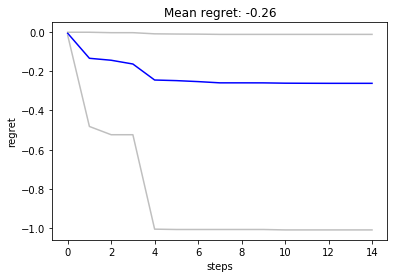

In [49]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()